This notebook shows the sequence of commands for an "end-to-end" verification. The idea is to show that we are able to 

    1 - Startup the telescope.
    2 - Acquire calibration data.
    3 - Initialize the observatory for the night.
    4 - Slew to a target.
    5 - Take an image of the target. 
    6 - Read the image from the butler and display it.
    7 - Shutdown the telescope.

The first step in this notebook is to load all the required libraries. 

In [1]:
import sys
import asyncio
import logging

import numpy as np

from lsst.ts import salobj


from lsst.ts.standardscripts.auxtel.attcs import ATTCS
from lsst.ts.standardscripts.auxtel.latiss import LATISS

In [2]:
import os
import lsst.daf.persistence as dafPersist

In [3]:
import matplotlib
%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (8, 6)
matplotlib.rcParams["font.size"] = 12

This next cell defines a method to display the image at the end. 

In [4]:
def display(image, mask=None, colors=None, alpha=0.40, **kwds):
    box = Box2D(image.getBBox())
    extent = (box.getMinX(), box.getMaxX(), box.getMinY(), box.getMaxY())
    kwds.setdefault("extent", extent)
    kwds.setdefault("origin", "lower")
    kwds.setdefault("interpolation", "nearest")
    matplotlib.pyplot.imshow(image.array, **kwds)
    kwds.pop("vmin", None)
    kwds.pop("vmax", None)
    kwds.pop("norm", None)
    kwds.pop("cmap", None)
    if mask is not None:
        for plane, color in colors.items():
            array = np.zeros(mask.array.shape + (4,), dtype=float)
            rgba = np.array(matplotlib.colors.hex2color(matplotlib.colors.cnames[color]) + (alpha, ),
                            dtype=float)
            np.multiply.outer((mask.array & mask.getPlaneBitMask(plane)).astype(bool), rgba, out=array)
            matplotlib.pyplot.imshow(array, **kwds)

In [5]:
from lsst.afw.geom import Box2D, Box2I, Point2I, Extent2I

Before proceeding, add a logger and set logging level to `DEBUG` so we can get status message from the various tasks.

In [6]:
stream_handler = logging.StreamHandler(sys.stdout)

logger = logging.getLogger()
logger.addHandler(stream_handler)
logger.level = logging.DEBUG

Next we initialize two high level classes to command the ATTCS and LATISS.

In [7]:
attcs = ATTCS()

Using selector: EpollSelector


In [8]:
latiss = LATISS(attcs.domain)

In [9]:
await asyncio.gather(attcs.start_task,
                     latiss.start_task)

Read historical data in 0.01 sec
Read historical data in 0.78 sec
Read historical data in 1.00 sec
Read historical data in 1.14 sec
Read historical data in 1.27 sec
Read historical data in 1.52 sec
Read historical data in 1.72 sec
Read historical data in 3.38 sec
Read historical data in 3.87 sec
Read historical data in 4.84 sec
Read historical data in 5.14 sec
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 26 messages


[[None, None, None, None, None, None, None], [None, None, None, None]]

Since there is no reason do put these components in standby at a given time, let us assume `LATISS` is already enabled. The same is not true for ATTCS which must be put in standby at the end of the night so the telescope can be left in a safe mode. 

For that we call the `enable` method in ATTCS. This will leave the telescope and its subsystems ready to go. 

Note that the ATHexapod simulator is not working right now. For that we can tell attcs to skip it in enable and startup operations.

In [10]:
attcs.check.athexapod = False

In [11]:
await attcs.enable(settings={
    'atmcs': "",
    'atptg': "",
    'ataos': "",
    'atpneumatics': "",
    'athexapod': "Default1",
    'atdome': "",
    'atdometrajectory': ""})

Gathering settings.
Settings versions: {'atmcs': '', 'atptg': '', 'ataos': '', 'atpneumatics': '', 'athexapod': 'Default1', 'atdome': '', 'atdometrajectory': ''}
Enabling all components
Enabling  atmcs
Enabling  atptg
Enabling  ataos
Enabling  atpneumatics
Enabling  atdome
Enabling  atdometrajectory
[atmcs]::[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]
[atptg]::[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]
[ataos]::[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]
[atpneumatics]::[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]
[athexapod]::<State.STANDBY: 5>
[atdome]::[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]
[atdometrajectory]::[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]
All components enabled.


Now we can use LATISS high level method `take_bias` to take a series of bias images.

In [ ]:
await latiss.take_bias(nbias=5)

There is also a method `take_darks` that can be used to take series of dark images.

In [ ]:
await latiss.take_darks(ndarks=5, exptime=15.)

It is also possible to take flat frames. For that, we would have to move the telescope and dome to the flat field position, switch on the lamps and take flat images.

We can position the telescope and dome with the `prepare_for_flatfield` method on the ATTCS. We don't have a simulator for flat lamps now so we will skip it.

In [12]:
await attcs.prepare_for_flatfield()

RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 34 messages
RemoteTelemetry(ATDome, 0, position) falling behind; read 34 messages
RemoteEvent(ATSpectrograph, 0, logMessage) falling behind; read 21 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 35 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 36 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 36 messages
RemoteEvent(ATPtg, 0, mountDataWarning) falling behind; read 13 messages
Flushing events
Scheduling check coroutines
Sending command
process as completed...
[Telescope] delta Alt = -019.176 | delta Az= +000.000 [Dome] delta Az = +000.000
[Telescope] delta Alt = -010.249 | delta Az= +000.000 [Dome] delta Az = +000.000
[Telescope] delta Alt = -001.042 | delta Az= +000.000 [Dome] delta Az = +000.000
Got True
Telescope in position.
[None, 'Telescope in position.']
Removing callback...
Timed out trying to get azimuth in position from the dome just aft

In [ ]:
await latiss.take_flats(exptime=5., nflats=5, filter='disperser', grating='ronchi170lpmm')

In [13]:
await attcs.startup()

Gathering settings.
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 39 messages
RemoteTelemetry(ATDome, 0, position) falling behind; read 38 messages
RemoteEvent(ATSpectrograph, 0, logMessage) falling behind; read 21 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 39 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 39 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 40 messages
RemoteEvent(ATPtg, 0, mountDataWarning) falling behind; read 14 messages
Settings versions: {'atmcs': '', 'atptg': '', 'ataos': 'current', 'atpneumatics': '', 'athexapod': 'Default1', 'atdome': 'test', 'atdometrajectory': ''}
Enabling all components
Enabling  atmcs
Enabling  atptg
Enabling  ataos
Enabling  atpneumatics
Enabling  atdome
Enabling  atdometrajectory
[atmcs]::[<State.ENABLED: 2>]
[atptg]::[<State.ENABLED: 2>]
[ataos]::[<State.ENABLED: 2>]
[atpneumatics]::[<State.ENABLED: 2>]
[athexapod]::<State.STANDBY: 5>
[atdome]

Select instrument port. This is not done at the startup.

In [14]:
await attcs.atmcs.cmd_setInstrumentPort.set_start(port=1)

RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 84 messages
RemoteTelemetry(ATDome, 0, position) falling behind; read 82 messages
RemoteEvent(ATAOS, 0, detailedState) falling behind; read 34 messages
RemoteEvent(ATSpectrograph, 0, heartbeat) falling behind; read 17 messages
RemoteEvent(ATDomeTrajectory, 0, heartbeat) falling behind; read 17 messages
RemoteEvent(ATMCS, 0, heartbeat) falling behind; read 17 messages
RemoteEvent(ATArchiver, 0, heartbeat) falling behind; read 17 messages
RemoteTelemetry(ATPneumatics, 0, m1AirPressure) falling behind; read 17 messages
RemoteEvent(ATHexapod, 0, heartbeat) falling behind; read 17 messages
RemoteEvent(ATHeaderService, 0, heartbeat) falling behind; read 17 messages
RemoteEvent(ATSpectrograph, 0, logMessage) falling behind; read 51 messages
RemoteEvent(ATAOS, 0, m1CorrectionStarted) falling behind; read 17 messages
RemoteTelemetry(ATMCS, 0, trajectory) falling behind; read 16 messages
RemoteTelemetry(ATPneumatics, 0, mainAirS

A trick to aways get a good target to point.

In [15]:
time = await attcs.atptg.tel_timeAndDate.aget()

RemoteEvent(ATDomeTrajectory, 0, heartbeat) falling behind; read 53 messages
RemoteEvent(ATArchiver, 0, heartbeat) falling behind; read 53 messages


In [16]:
time.lst

'21:59:32.6'

In [17]:
await attcs.slew_icrs(ra=time.lst, dec=-50., slew_timeout=120)

RemoteTelemetry(ATPtg, 0, skyEnvironment) falling behind; read 11 messages
RemoteEvent(ATAOS, 0, m1CorrectionStarted) falling behind; read 53 messages
RemoteTelemetry(ATMCS, 0, trajectory) falling behind; read 52 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 100 messages
RemoteEvent(ATAOS, 0, m1CorrectionCompleted) falling behind; read 54 messages
RemoteEvent(ATSpectrograph, 0, heartbeat) falling behind; read 55 messages
RemoteTelemetry(ATMCS, 0, torqueDemand) falling behind; read 52 messages
RemoteTelemetry(ATPtg, 0, currentTimesToLimits) falling behind; read 11 messages
Flushing events
Scheduling check coroutines
Sending command
ATDome in position.
process as completed...
[Telescope] delta Alt = +009.784 | delta Az= +179.304 [Dome] delta Az = -000.140
[Telescope] delta Alt = +001.626 | delta Az= +170.671 [Dome] delta Az = -000.127
[Telescope] delta Alt = -000.000 | delta Az= +160.541 [Dome] delta Az = -000.110
[Telescope] delta Alt = -000.000 | delta Az= 

In [18]:
end_readout = await latiss.take_image(exptime=10., 
                                      shutter=True, 
                                      image_type="OBJECT", 
                                      group_id="TEST", 
                                      filter="disperser", 
                                      grating="ronchi170lpmm")

RemoteEvent(ATMCS, 0, target) falling behind; read 100 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 100 messages
RemoteTelemetry(ATDome, 0, position) falling behind; read 100 messages
RemoteEvent(ATArchiver, 0, heartbeat) falling behind; read 26 messages
RemoteEvent(ATAOS, 0, detailedState) falling behind; read 50 messages
RemoteEvent(ATHexapod, 0, heartbeat) falling behind; read 26 messages
RemoteEvent(ATSpectrograph, 0, logMessage) falling behind; read 72 messages
RemoteTelemetry(ATPneumatics, 0, m1AirPressure) falling behind; read 25 messages
RemoteEvent(ATHeaderService, 0, heartbeat) falling behind; read 25 messages
RemoteEvent(ATAOS, 0, m1CorrectionStarted) falling behind; read 26 messages
RemoteEvent(ATAOS, 0, m1CorrectionCompleted) falling behind; read 26 messages
RemoteTelemetry(ATPneumatics, 0, mainAirSourcePressure) falling behind; read 25 messages
RemoteTelemetry(ATMCS, 0, 

In [19]:
print(end_readout)

private_revCode: 91cd7826, private_sndStamp: 1574203845.189425, private_rcvStamp: 1574203845.1901925, private_seqNum: 0, private_origin: 1, private_host: 0, imageType: OBJECT, groupId: TEST, imagesInSequence: 1, imageName: AT_O_20191119_000001, imageIndex: 0, imageSource: AT, imageController: O, imageDate: 20191119, imageNumber: 1, timeStampAcquisitionStart: 1574203795.381, exposureTime: 10.0, timeStampEndOfReadout: 1574203845.1891396, priority: 1


Get visit id from the `end_readout` event. 

In [20]:
visit = int(int(f"{end_readout.imageDate}{end_readout.imageNumber:05}"))
print(visit)

2019111900001


In [21]:
await asyncio.sleep(15.)

RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
RemoteTelemetry(ATDome, 0, position) falling behind; read 100 messages
RemoteEvent(ATMCS, 0, target) falling behind; read 100 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 100 messages
RemoteEvent(ATAOS, 0, detailedState) falling behind; read 46 messages
RemoteTelemetry(ATPneumatics, 0, m1AirPressure) falling behind; read 23 messages
RemoteEvent(ATSpectrograph, 0, heartbeat) falling behind; read 23 messages
RemoteEvent(ATArchiver, 0, heartbeat) falling behind; read 23 messages
RemoteEvent(ATHexapod, 0, heartbeat) falling behind; read 23 messages
RemoteEvent(ATDomeTrajectory, 0, heartbeat) falling behind; read 23 messages
RemoteEvent(ATHeaderService, 0, logMessage) falling behind; read 11 messages
RemoteTelemetry(ATPneumatics, 0, mainAirSourcePressure) falling behind; read 23 messages
RemoteEvent(ATSpectrograph, 0, logMessage) falling behind; read 66 messages
RemoteTelemetry(ATM

In [22]:
repo = os.path.join("/mnt/dmcs/oods_butler_repo/repo")
butler = dafPersist.Butler(repo)

In [23]:
raw = butler.get("raw", visit=visit)

Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20191119_000001.yaml
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20191119_000001.yaml
Using translation class LSST_LATISS


update_title_pos


/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Call to deprecated function (or staticmethod) Box2D. (Replaced by lsst.geom.Box2D (will be removed before the release of v20.0))
  


findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
update_title_pos
update_title_pos
update_title_pos
update_title_pos


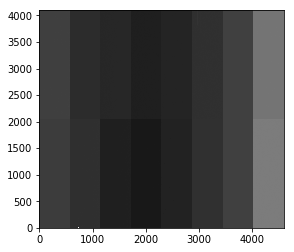

In [24]:
display(raw.image, cmap=matplotlib.cm.gray, vmin=1e4, vmax=3e4)

Finaly, shutdown the system. 

In [25]:
await attcs.shutdown()

Disabling ATAOS corrections
RemoteEvent(ATMCS, 0, target) falling behind; read 100 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 100 messages
RemoteTelemetry(ATDome, 0, position) falling behind; read 100 messages
RemoteEvent(ATHeaderService, 0, heartbeat) falling behind; read 40 messages
RemoteEvent(ATSpectrograph, 0, heartbeat) falling behind; read 40 messages
RemoteTelemetry(ATPneumatics, 0, m1AirPressure) falling behind; read 40 messages
RemoteEvent(ATAOS, 0, m1CorrectionStarted) falling behind; read 39 messages
RemoteEvent(ATHexapod, 0, heartbeat) falling behind; read 40 messages
RemoteEvent(ATArchiver, 0, heartbeat) falling behind; read 40 messages
RemoteEvent(ATAOS, 0, detailedState) falling behind; read 78 messages
RemoteTelemetry(ATMCS, 0, trajectory) falling behind; read 39 messages
RemoteEvent(ATSpectrograph, 0, logMessage) falling behind; read 100 messages
RemoteTelemetry(AT